<h3 style='color:blue' align='center'>Customer Churn Prediction Using Artificial Neural Network (ANN)</h3>

Customer churn prediction is to measure why customers are leaving a business. In this tutorial we will be looking at customer churn in telecom business. We will build a deep learning model to predict the churn and use precision,recall, f1-score to measure performance of our model

# 1. Importing Libraries

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# 2. Data Exploration and Preprocessing

In [106]:
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [107]:
# Display sample data
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [108]:
df.shape

(7043, 21)

In [109]:
# Drop unnecessary column
df.drop('customerID', axis='columns', inplace=True)


In [110]:
# Convert TotalCharges to numeric and handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)  # Fill missing values with the mean


<ipython-input-110-1c8b5e4b4852>:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [111]:
# Replace 'No internet service' and 'No phone service'
df.replace({'No internet service': 'No', 'No phone service': 'No'}, inplace=True)

In [112]:
df.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


# 3. Exploratory Data Analysis

In [113]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Labels for the charts
g_labels = ['Male', 'Female']
c_labels = ['No', 'Yes']

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'domain'}, {'type': 'domain'}]])

# Add gender distribution pie chart
fig.add_trace(go.Pie(labels=g_labels, values=df['gender'].value_counts(), name="Gender"), row=1, col=1)

# Add 'churn' distribution pie chart
fig.add_trace(go.Pie(labels=c_labels, values=df['Churn'].value_counts(), name="Churn"), row=1, col=2)

# Use `hole` to create donut-like pie charts
fig.update_traces(hole=0.4, hoverinfo="label+percent+name", textfont_size=16)

# Update layout and titles
fig.update_layout(
    title_text="Gender and Churn Distributions",
    # Add annotations in the center of the donut pies
    annotations=[dict(text='Gender', x=0.20, y=0.5, font_size=20, showarrow=False),
                 dict(text='Churn', x=0.79, y=0.5, font_size=20, showarrow=False)]
)

fig.show()


In [114]:
df["Churn"][df["Churn"]=="No"].groupby(by=df["gender"]).count()

,Churn
gender,
Female,2549
Male,2625


In [115]:

df["Churn"][df["Churn"]=="Yes"].groupby(by=df["gender"]).count()

,Churn
gender,
Female,939
Male,930


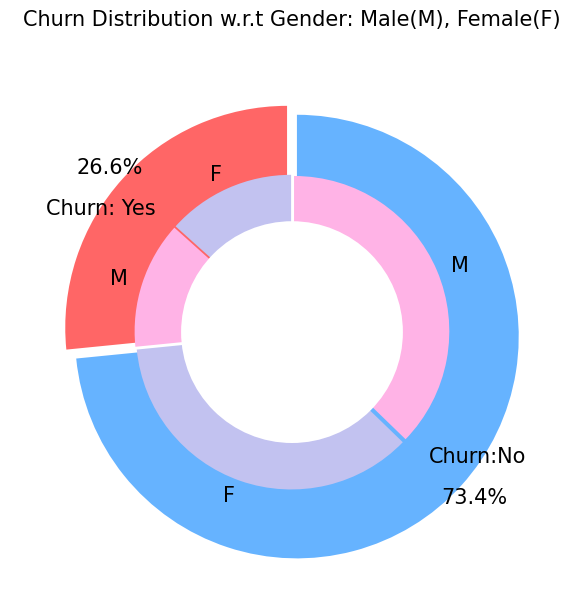

In [116]:
plt.figure(figsize=(6, 6))
labels =["Churn: Yes","Churn:No"]
values = [1869,5163]
labels_gender = ["F","M","F","M"]
sizes_gender = [939,930 , 2544,2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3,0.3)
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution w.r.t Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# show plot

plt.axis('equal')
plt.tight_layout()
plt.show()


In [117]:
fig = px.histogram(df, x="Churn", color="Contract", barmode="group", title="<b>Customer contract distribution<b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [118]:
labels = df['PaymentMethod'].unique()
values = df['PaymentMethod'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="<b>Payment Method Distribution</b>")
fig.show()

In [79]:
fig = px.histogram(df, x="Churn", color="PaymentMethod", title="<b>Customer Payment Method distribution w.r.t. Churn</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [80]:
df["InternetService"].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [81]:
 df[df["gender"]=="Male"][["InternetService", "Churn"]].value_counts()

,,count
InternetService,Churn,
DSL,No,993
Fiber optic,No,910
No,No,722
Fiber optic,Yes,633
DSL,Yes,240
No,Yes,57


In [82]:

df[df["gender"]=="Female"][["InternetService", "Churn"]].value_counts()

,,count
InternetService,Churn,
DSL,No,969
Fiber optic,No,889
No,No,691
Fiber optic,Yes,664
DSL,Yes,219
No,Yes,56


In [83]:
fig = go.Figure()

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [965, 992, 219, 240],
  name = 'DSL',
))

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [889, 910, 664, 633],
  name = 'Fiber optic',
))

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [690, 717, 56, 57],
  name = 'No Internet',
))

fig.update_layout(title_text="<b>Churn Distribution w.r.t. Internet Service and Gender</b>")

fig.show()

In [84]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(df, x="Churn", color="Dependents", barmode="group", title="<b>Dependents distribution</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [85]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(df, x="Churn", color="Partner", barmode="group", title="<b>Chrun distribution w.r.t. Partners</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [86]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df, x="Churn", color="SeniorCitizen", title="<b>Chrun distribution w.r.t. Senior Citizen</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [87]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(df, x="Churn", color="OnlineSecurity", barmode="group", title="<b>Churn w.r.t Online Security</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [88]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(df, x="Churn", color="PaperlessBilling",  title="<b>Chrun distribution w.r.t. Paperless Billing</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [89]:
fig = px.histogram(df, x="Churn", color="TechSupport",barmode="group",  title="<b>Chrun distribution w.r.t. TechSupport</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [90]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df, x="Churn", color="PhoneService", title="<b>Chrun distribution w.r.t. Phone Service</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

<ipython-input-91-9321107cf963>:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-91-9321107cf963>:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




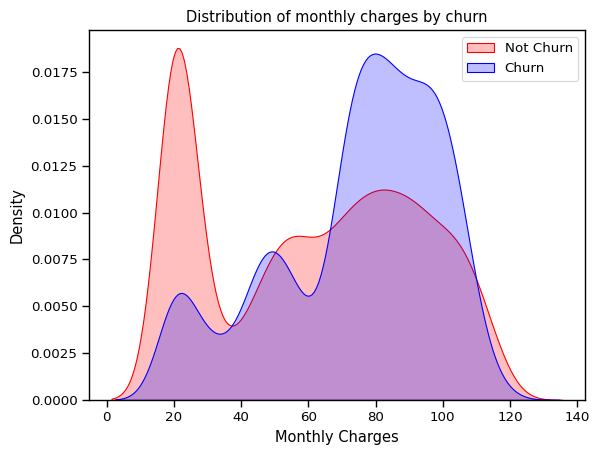

In [91]:

sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'No') ],
                color="Red", shade = True);
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True);
ax.legend(["Not Churn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Monthly Charges');
ax.set_title('Distribution of monthly charges by churn');

<ipython-input-92-21edbc902f70>:1: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-92-21edbc902f70>:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




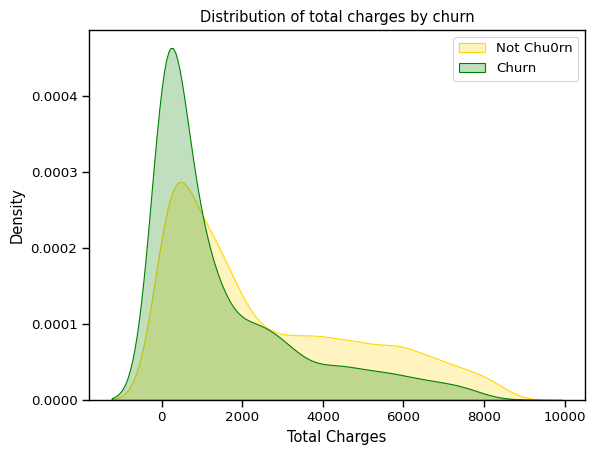

In [92]:

ax = sns.kdeplot(df.TotalCharges[(df["Churn"] == 'No') ],
                color="Gold", shade = True);
ax = sns.kdeplot(df.TotalCharges[(df["Churn"] == 'Yes') ],
                ax =ax, color="Green", shade= True);
ax.legend(["Not Chu0rn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Total Charges');
ax.set_title('Distribution of total charges by churn');

In [93]:
fig = px.box(df, x='Churn', y = 'tenure')

# Update yaxis properties
fig.update_yaxes(title_text='Tenure (Months)', row=1, col=1)
# Update xaxis properties
fig.update_xaxes(title_text='Churn', row=1, col=1)

# Update size and title
fig.update_layout(autosize=True, width=750, height=600,
    title_font=dict(size=25, family='Courier'),
    title='<b>Tenure vs Churn</b>',
)

fig.show()

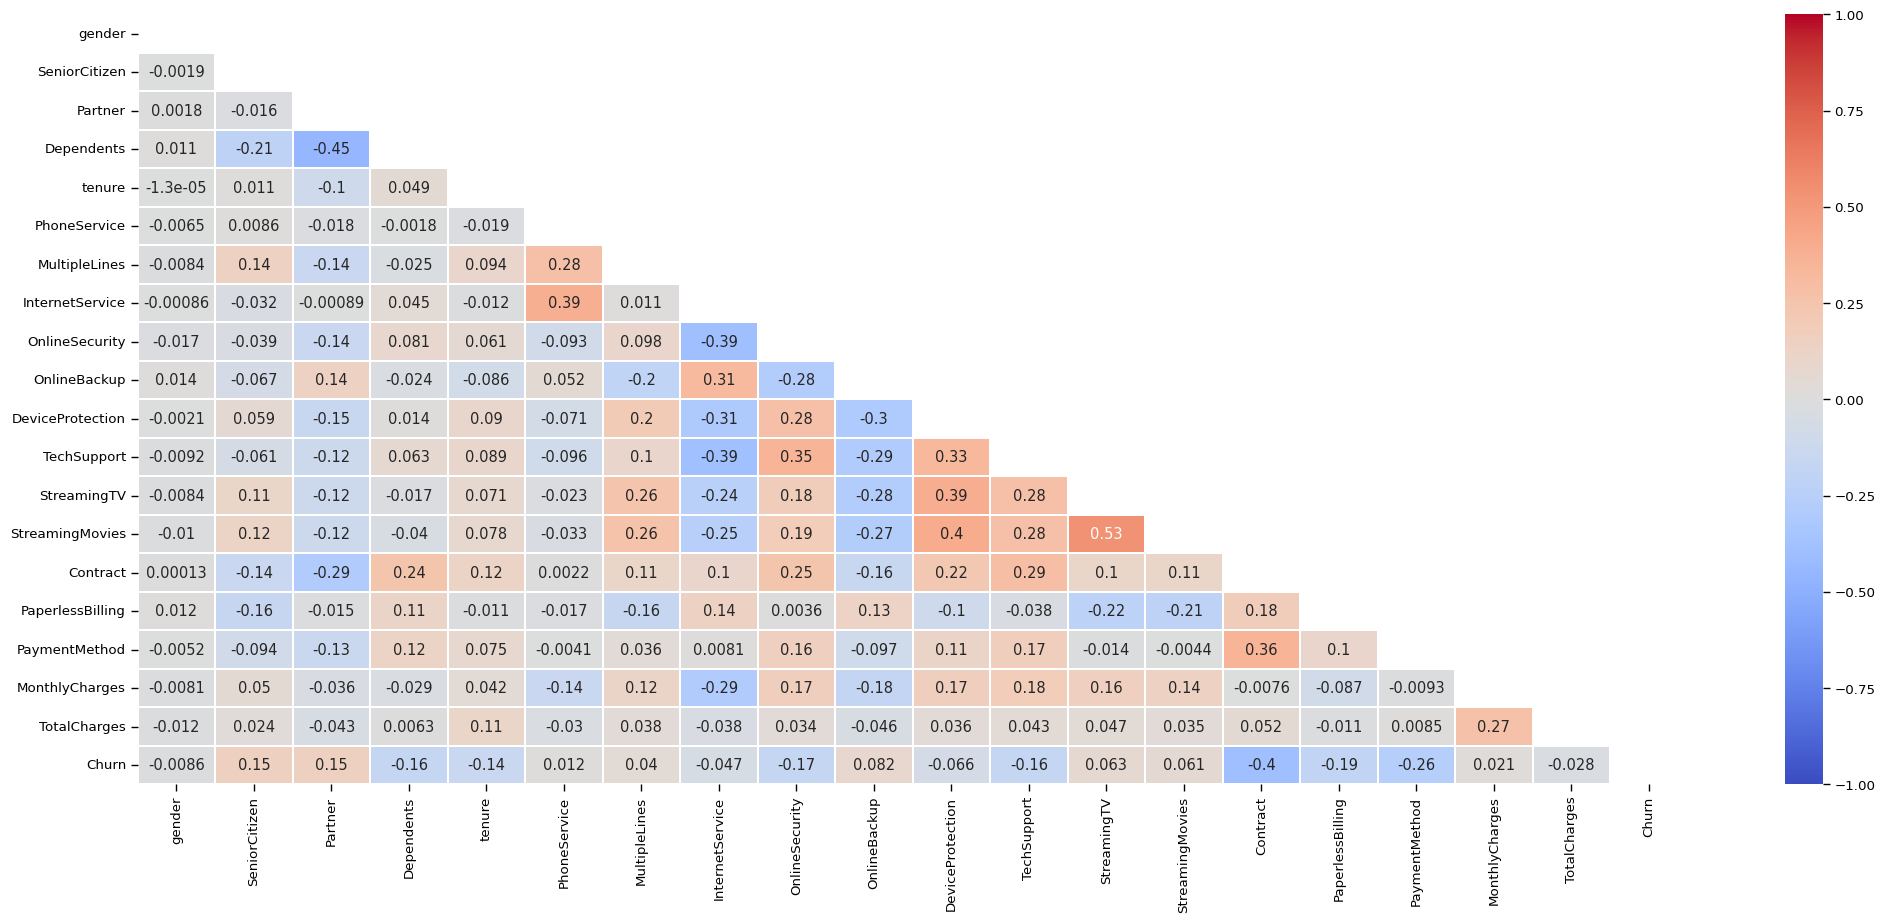

In [94]:
plt.figure(figsize=(25, 10))

corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

In [119]:
# Convert categorical variables to numerical
yes_no_columns = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                  'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                  'TechSupport', 'StreamingTV', 'StreamingMovies',
                  'PaperlessBilling', 'Churn']

In [120]:
for col in yes_no_columns:
    df[col].replace({'Yes': 1, 'No': 0}, inplace=True)

<ipython-input-120-74473f5cbc11>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-120-74473f5cbc11>:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [121]:
# Encode gender
df['gender'].replace({'Female': 1, 'Male': 0}, inplace=True)

# Create dummy variables for categorical columns
df = pd.get_dummies(data=df, columns=['InternetService', 'Contract', 'PaymentMethod'])

<ipython-input-121-0c864154040a>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-121-0c864154040a>:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [122]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,True,False,False,True,False,False,False,False,True,False
1,0,0,0,0,34,1,0,1,0,1,...,True,False,False,False,True,False,False,False,False,True
2,0,0,0,0,2,1,0,1,1,0,...,True,False,False,True,False,False,False,False,False,True
3,0,0,0,0,45,0,0,1,0,1,...,True,False,False,False,True,False,True,False,False,False
4,1,0,0,0,2,1,0,0,0,0,...,False,True,False,True,False,False,False,False,True,False


In [123]:
# Normalize numerical features
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [124]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,0.013889,0,0,0,1,0,...,True,False,False,True,False,False,False,False,True,False
1,0,0,0,0,0.472222,1,0,1,0,1,...,True,False,False,False,True,False,False,False,False,True
2,0,0,0,0,0.027778,1,0,1,1,0,...,True,False,False,True,False,False,False,False,False,True
3,0,0,0,0,0.625000,0,0,1,0,1,...,True,False,False,False,True,False,True,False,False,False
4,1,0,0,0,0.027778,1,0,0,0,0,...,False,True,False,True,False,False,False,False,True,False


In [13]:
# Separate features and target variable
X = df.drop('Churn', axis='columns')
y = df['Churn']

# 4. Handling class imbalance using SMOTE

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

# Apply SMOTE to the training set
smote = SMOTE(random_state=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [126]:
X_train_smote.shape, y_train_smote.shape

((8278, 26), (8278,))


# 5. Model Building and Model Evaluation

In [15]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

In [16]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_smote, y_train_smote)
print("Logistic Regression Evaluation:")
evaluate_model(lr_model, X_test, y_test)

Logistic Regression Evaluation:
Confusion Matrix:
[[807 228]
 [ 97 277]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.55      0.74      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409



In [17]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=5)
rf_model.fit(X_train_smote, y_train_smote)
print("\nRandom Forest Evaluation:")
evaluate_model(rf_model, X_test, y_test)


Random Forest Evaluation:
Confusion Matrix:
[[861 174]
 [133 241]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1035
           1       0.58      0.64      0.61       374

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.78      0.79      1409



In [18]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(random_state=5)
gb_model.fit(X_train_smote, y_train_smote)
print("\nGradient Boosting Evaluation:")
evaluate_model(gb_model, X_test, y_test)


Gradient Boosting Evaluation:
Confusion Matrix:
[[799 236]
 [ 91 283]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1035
           1       0.55      0.76      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409




# 6. Customer Segmentation

In [19]:
from sklearn.cluster import KMeans

# Selecting features for clustering
features_for_clustering = df[['tenure', 'MonthlyCharges', 'TotalCharges']]
kmeans = KMeans(n_clusters=3, random_state=5)
df['Cluster'] = kmeans.fit_predict(features_for_clustering)

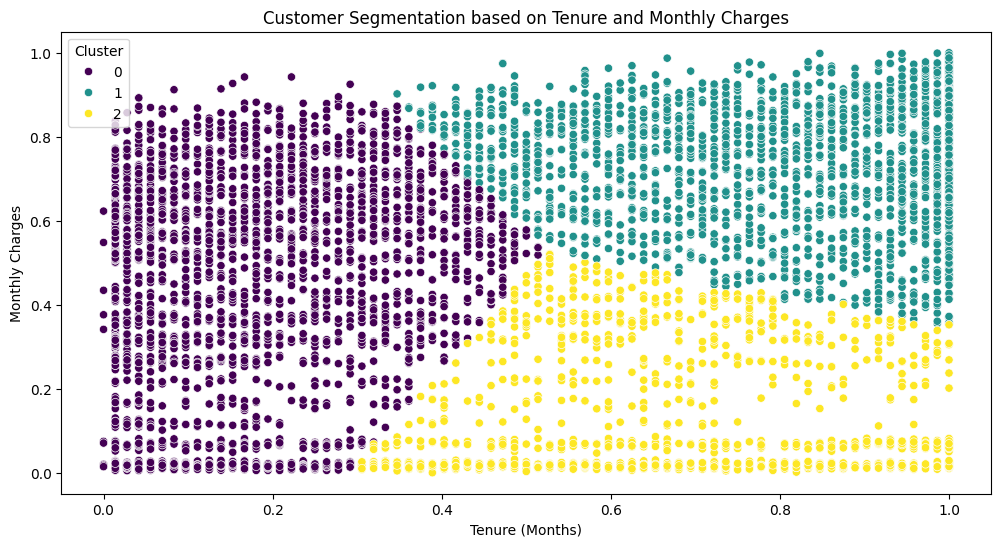

In [20]:
# Visualize customer segments
plt.figure(figsize=(12, 6))
sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Cluster', data=df, palette='viridis')
plt.title('Customer Segmentation based on Tenure and Monthly Charges')
plt.xlabel('Tenure (Months)')
plt.ylabel('Monthly Charges')
plt.show()

# 7. Model Evaluation (using ROC-AUC)

In [21]:
from sklearn.metrics import roc_auc_score

# Calculate ROC-AUC for Random Forest as an example
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score for Random Forest: {roc_auc:.2f}")

ROC AUC Score for Random Forest: 0.83


# 8. Interpretability and Visualization (Using SHAP values)

In [25]:
# Check the shape of SHAP values
print(f"Shape of SHAP values: {shap_values[0].shape}, {shap_values[1].shape}")



Shape of SHAP values: (26, 2), (26, 2)


In [30]:
print(X_train_encoded.dtypes)



gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                     float64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
InternetService_DSL                           bool
InternetService_Fiber optic                   bool
InternetService_No                            bool
Contract_Month-to-month        

In [34]:
# Convert all boolean columns to integers (0 and 1)
X_train_encoded = X_train_encoded.astype({col: 'int' for col in X_train_encoded.select_dtypes(include='bool').columns})


In [35]:
print(X_train_encoded.dtypes)



gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                     float64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
InternetService_DSL                          int64
InternetService_Fiber optic                  int64
InternetService_No                           int64
Contract_Month-to-month        

In [45]:
explainer = shap.TreeExplainer(rf_model, X_train_encoded)
explainer.check_additivity = False

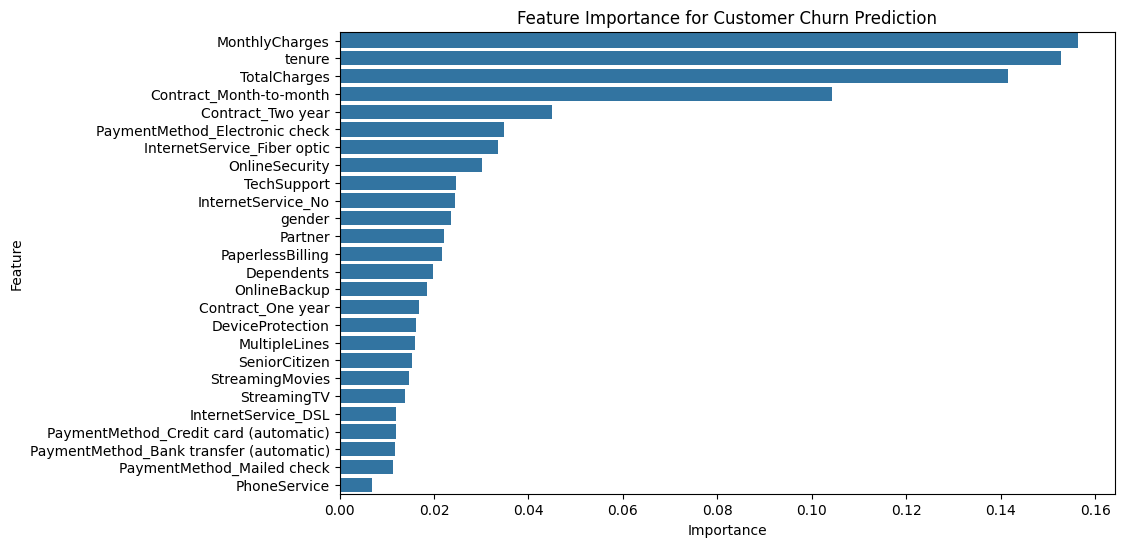

In [23]:
# Feature Importance from Random Forest
importances = rf_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names[indices],
    'Importance': importances[indices]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Customer Churn Prediction')
plt.show()
